In [31]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib


In [32]:
# Cell 2: Load & Preprocess
csv_path = 'pet_feeder_near_mealtimes_with_noise.csv'

In [33]:
# Parse timestamps and distances

def parse_ts(x):
    for fmt in ('%d/%m/%y %H:%M:%S','%Y-%m-%d %H:%M:%S','%y.%m.%d %H.%M.%S'):
        try: return datetime.strptime(x, fmt)
        except: continue
    return pd.NaT

df = pd.read_csv(csv_path)
df['timestamp'] = df['timestamp'].astype(str).apply(parse_ts)
df['distance_cm'] = pd.to_numeric(
    df['distance_cm'].astype(str).str.replace(',','.'), errors='coerce')

In [34]:
# Count anomalies
counts = {
    'missing_timestamps': df['timestamp'].isna().sum(),
    'missing_distances': df['distance_cm'].isna().sum(),
    'outliers':   (df['distance_cm']>20).sum(),
    'negatives':  (df['distance_cm']<0).sum(),
    'duplicates': df.duplicated().sum()
}
print("Anomaly counts:", counts)

Anomaly counts: {'missing_timestamps': 0, 'missing_distances': 694, 'outliers': 144, 'negatives': 72, 'duplicates': 144}


In [35]:
# Drop anomalies
df = df.dropna(subset=['timestamp','distance_cm'])
df = df[(df['distance_cm']>=0)&(df['distance_cm']<=20)].drop_duplicates()

In [36]:
# Focus on 'near feeder' events
 # Compute seconds-of-day for each timestamp
df['sec_of_day'] = (
     df['timestamp'].dt.hour * 3600 +
     df['timestamp'].dt.minute * 60 +
     df['timestamp'].dt.second
 )

In [37]:
# Cell 3: Fit KMeans to find 3 meal-time clusters and evaluate
X = df['sec_of_day'].values.reshape(-1,1)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

C:\Users\Wijesingha\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [38]:
# Evaluate clustering quality
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score for 3 clusters: {sil_score:.3f}")

centers = np.sort(kmeans.cluster_centers_.flatten())  # sorted meal times (hh:mm:ss):", meal_times)

Silhouette Score for 3 clusters: 0.905


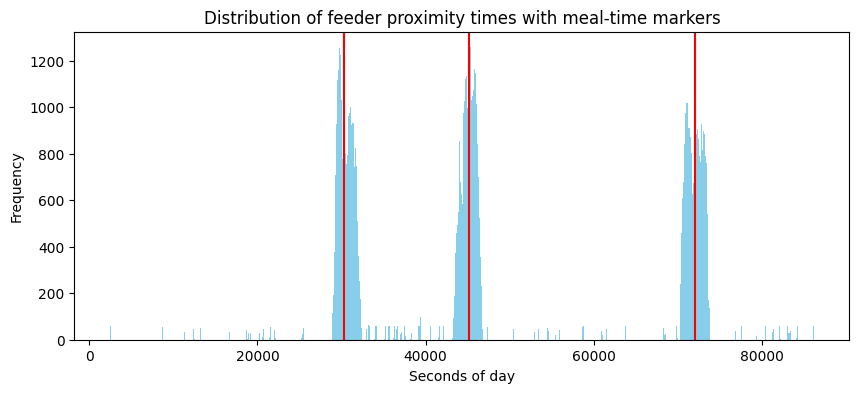

In [39]:
# Cell 4: Visualize clusters
plt.figure(figsize=(10,4))
plt.hist(X.flatten(), bins=1440, color='skyblue')
for c in centers:
    plt.axvline(c, color='red')
plt.title('Distribution of feeder proximity times with meal-time markers')
plt.xlabel('Seconds of day')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Cell 5: Save KMeans model
import joblib
# Save the trained KMeans model directly using joblib for consistency
def save_model(model, path):
    joblib.dump(model, path)

# Persist the model to disk
save_model(kmeans, 'meal_time_kmeans.pkl')
print('KMeans model saved to meal_time_kmeans.pkl')

KMeans model saved to meal_time_kmeans.pkl
